In [560]:
import rasterio as rio
import rasterio.mask
from rasterio.io import MemoryFile 
import boto3
import s3fs
from datetime import datetime
from datetime import timedelta
from itertools import chain
import requests
import subprocess
import tempfile
import os
import shutil
import numpy as np
from numpy import ma
from functools import reduce
from functools import partial
import pyproj
from glob import glob

from dask.distributed import Client
from dask import delayed

from io import BytesIO

import xarray as xr

import geopandas as gpd

import pandas as pd

from shapely import geometry
from shapely import ops

import matplotlib.pyplot as plt
from cmr import GranuleQuery

MODIS_CMR_COLLECTION_NAME = "MODISA_L3m_CHL"
MODIS_YEARS = {
    'start': pd.to_datetime("20020704"), 
    'end': pd.to_datetime("20210101")
}

## Download MODIS data to validate MHWs

We need to download MODIS Chlorophyll-a data in order to validate physiological responses to MHWs. MODIS captures much of the planet every day, so we can relatively easily try to assess all detected MHWs. There are a few caveats to this:
* MODIS measurement swaths do not overlap -- while all latitudes are covered by MODIS measurements, all longitudes are not, in a single day. 
* There are 8 day gridded products which are likely to have full-planet coverage, so we could use those (+ limit MHW length to 8 days minimum?)
* we could also try to get all MODIS products for the duration of a MHW and just aggregate the ones that contain data

In [2]:
plankton = pd.read_csv("../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

plankton = plankton.set_index('isolate.code')

plankton = plankton[
    (plankton.habitat == 'marine') & 
    (plankton.curvequal == 'good')
]

plankton = plankton.dropna(axis=0, subset=['isolation.latitude', 'isolation.longitude'])

len(plankton)


89

In [3]:
mhws = pd.read_csv("../../analysis/isolate_performance_withnegative.csv", parse_dates = ['peak_date', 'start_date'])
mhws.head()

,Unnamed: 0,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
0,0,-74.875,164.625,1,4.0,3.433027,1.303966,0.429128,0.237193,0.078059,...,1.297811,9.0,1,1,-1.202301,1986-12-31,536457600000000000,0.846135,"(-75.026, -59.75]","(0.639, 91.25]"
1,1,-74.875,164.625,1,5.0,6.265167,1.269172,0.417678,0.287250,0.094533,...,1.528319,16.0,21,32,-1.103370,1987-01-21,539136000000000000,0.815611,"(-75.026, -59.75]","(0.639, 91.25]"
2,2,-74.875,164.625,1,11.0,9.585366,1.713322,0.563845,0.035686,0.011744,...,0.187730,18.0,232,244,-1.168743,1988-08-19,588988800000000000,0.979598,"(-75.026, -59.75]","(181.5, 271.75]"
3,3,-74.875,164.625,1,14.0,10.139295,1.711648,0.563294,0.033256,0.010944,...,0.174102,19.0,196,201,-1.181397,1989-07-15,616896000000000000,0.980941,"(-75.026, -59.75]","(181.5, 271.75]"
4,4,-74.875,164.625,1,37.0,6.210158,1.715494,0.564560,0.029738,0.009786,...,0.156030,12.0,215,220,-1.219370,1995-08-03,807840000000000000,0.982961,"(-75.026, -59.75]","(181.5, 271.75]"


## Analysis Design
 
### Grab a set of isolates that are not too close to shore (how close?)

In [4]:
min_land_distance_m = 500 * 1000 # 1000 km 

In [5]:
len(plankton.index.unique())
isolate_locations = gpd.GeoSeries(
    [
        geometry.Point(p['isolation.longitude'], p['isolation.latitude'])
        for _, p in plankton.dropna(axis=0, subset=['isolation.longitude', 'isolation.latitude']).groupby('isolate.code').head(1)[['isolation.latitude', 'isolation.longitude']].iterrows()
    ],
    index=plankton.index,
    crs={'init': 'epsg:4326'}
)

In [6]:
isolate_locations.head()

isolate.code
1     POINT (164.50000 -74.83000)
3     POINT (110.48000 -66.28000)
5     POINT (-64.06000 -64.78000)
11     POINT (62.00000 -58.00000)
14    POINT (168.12000 -46.98000)
dtype: geometry

In [7]:
# Natural Earth Land Polygons (https://www.naturalearthdata.com/)
landmasses = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip", crs='EPSG:4326').to_crs(epsg=3857)

In [8]:
distances =  isolate_locations.to_crs(epsg=3857).distance(landmasses.cascaded_union).sort_values(ascending=False)

In [9]:
plankton['land_distance'] = distances

In [10]:
distant_plankton =plankton[plankton.land_distance > min_land_distance_m]

### How many MHW days have each of these experienced?

In [11]:
mhws[mhws.isolate.isin(distant_plankton.index)].groupby('isolate').duration.sum().sort_values(ascending=False)

isolate
365    1213.0
240    1094.0
364     999.0
89      911.0
558     909.0
45      868.0
11      863.0
358     833.0
Name: duration, dtype: float64

### Select MHW and non-MHW time periods for these isolates 

In [12]:
chosen_isolates = distant_plankton.head(2).index
chosen_isolates

Int64Index([11, 45], dtype='int64', name='isolate.code')

In [13]:
plankton.loc[chosen_isolates]

,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,clone,...,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis,land_distance
isolate.code,,,,,,,,,,,,,,,,,,,,,
11,"Southern Ocean, Indian sector",-58.00,62.00,marine,Pseudo-nitzschia turgiduloides,Pseudo-nitzschia turgiduloides,Nitzschia turgiduloides,NaN,NaN,NaN,...,good,good,-4.634105,-0.004083,1.0,1.0,1.0,1.0,1.0,1.590694e+06
45,NaN,-11.54,-28.58,marine,Pernambugia tuberosa strain GeoB*74,Pernambugia tuberosa,NaN,NaN,GeoB*74,NaN,...,good,good,-85.503149,-0.009196,1.0,1.0,1.0,1.0,1.0,7.895010e+05


Find the MHWs from these chosen isolates that are covered by the MODIS chlorophyll record:

In [14]:
chosen_isolate_mhws = mhws[mhws.isolate.isin(chosen_isolates) & mhws.start_date.between(MODIS_YEARS['start'], MODIS_YEARS['end'])]
print(len(chosen_isolate_mhws), "MHWS for chosen isolates during MODIS temporal availabilty")

81 MHWS for chosen isolates during MODIS temporal availabilty


Select MHW and non-MHW adjacent periods for top 10 longest MHWs for each isolate:

In [15]:
top_isolate_mhws = chosen_isolate_mhws.groupby('isolate').apply(lambda x: x.sort_values('duration', ascending=False).head(10))

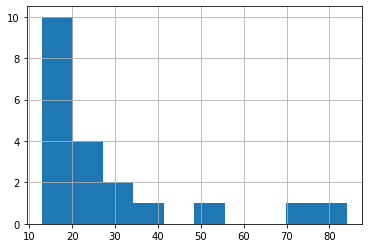

In [16]:
top_isolate_mhws.duration.hist()

I feel like we probably don't want to include those really long MHWs? Will keep them for now

In [17]:
mhw_periods = top_isolate_mhws.apply(lambda x: [x.start_date, x.start_date + timedelta(days=x.duration)], axis=1)

Compute non-mhw periods by adding ~5 days on either end of the MHW event? (2 periods / isolate?)

In [18]:
non_mhw_periods = top_isolate_mhws.apply(
    lambda x: [
        [x.start_date - timedelta(days=6), x.start_date - timedelta(days=1)],
        [x.start_date + timedelta(days=x.duration + 1), x.start_date + timedelta(days= x.duration + 6)]
    ], 
    axis=1
)

Get a list of days for which we need MODIS data: 

In [239]:
from operator import or_
data_needed = (reduce(or_, (map(lambda x: pd.date_range(x[0], x[1]), list(chain(mhw_periods.values))))))

Since we're going to use the 8Day Mapped Product from MODIS, we want to know which 8 day period each of these days belong to. 

In [266]:
periods = reduce(or_, 
                 (pd.period_range(start=pd.datetime(year, 1, 1),
                                  end=pd.datetime(year, 12, 31),
                                  freq='8D')
                  for year in range(2002, 2021))
                )

In [267]:
data_needed.map(lambda x: periods.asof(x))

PeriodIndex(['2002-08-05', '2002-08-05', '2002-08-05', '2002-08-05',
             '2002-08-13', '2002-08-13', '2002-08-13', '2002-08-13',
             '2002-08-13', '2002-08-13',
             ...
             '2018-04-07', '2018-04-07', '2018-04-07', '2018-04-07',
             '2018-04-15', '2018-04-15', '2018-04-15', '2018-04-15',
             '2018-04-15', '2018-04-15'],
            dtype='period[8D]', length=561, freq='8D')

In [303]:
data_needed = data_needed.to_frame()

In [304]:
data_needed['doy'] = data_needed.iloc[:,0].dt.dayofyear

In [306]:
pd.merge_asof(data_needed, )

PeriodIndex(['2002-01-01', '2002-01-09', '2002-01-17', '2002-01-25',
             '2002-02-02', '2002-02-10', '2002-02-18', '2002-02-26',
             '2002-03-06', '2002-03-14',
             ...
             '2020-10-15', '2020-10-23', '2020-10-31', '2020-11-08',
             '2020-11-16', '2020-11-24', '2020-12-02', '2020-12-10',
             '2020-12-18', '2020-12-26'],
            dtype='period[8D]', length=874, freq='8D')

In [314]:
periods = periods.to_frame()

In [315]:
periods['start-doy'] = periods.iloc[:,0].dt.dayofyear

In [320]:
dates_with_doy = pd.merge_asof(data_needed.sort_values('doy'), periods.sort_values('start-doy'), left_on='doy', right_on='start-doy', )

In [324]:
dates_with_doy = dates_with_doy.rename({
    '0_x' : 'date',
}, axis=1)[['date', 'start-doy']]

In [362]:
unique_dates_with_doy = pd.DataFrame.from_records(list(set(zip(dates_with_doy.date.dt.year, dates_with_doy['start-doy']))), columns=['year', 'start-doy'])

## Download Data

In [135]:
MODIS_URL_TEMPLATE = (
    "https://oceandata.sci.gsfc.nasa.gov/ob/getfile/"
    "{satellite[0]}{year}{doy_start:03d}{year}{doy_end:03d}.L3m_{prod}_CHL_chlor_a_{res_km}km.nc"
)

In [370]:
urls = list(map(
    lambda x: MODIS_URL_TEMPLATE.format(
                year=x[1].year,
                res_km=4, 
                satellite="Terra",
                doy_start=x[1]['start-doy'],
                doy_end=x[1]['start-doy'] + 7 if x[1]['start-doy'] < 361 else pd.to_datetime(pd.datetime(x[1].year, 12, 31)).dayofyear, #leapyears
                prod='8D'
    ), 
    unique_dates_with_doy.iterrows()
))

In [22]:
username = os.environ['EARTHDATA_USERNAME']
password = os.environ['EARTHDATA_PASSWORD']

! echo "machine urs.earthdata.nasa.gov login {username} password {password}" > ~/.netrc && chmod 0600 ~/.netrc
! touch .urs_cookies

In [507]:
@delayed
def download_modis(url, suffix, outdir='.'):
    with tempfile.TemporaryDirectory() as tempdir:
        original = tempfile.mkstemp(dir=tempdir, suffix='.nc')
        subprocess.run(f"curl --output {original[1]} -b ~/.urs_cookies -c ~/.urs_cookies -L -n {url} ", shell=True)
        subprocess.run(f"gdal_translate -co COMPRESS=LZW -a_srs EPSG:4326 -sds {original[1]} {tempdir}/outputs.tif", shell=True)
        shutil.copy(
            os.path.join(tempdir, 'outputs_1.tif'),
            os.path.join(outdir, f"{suffix}.tif")
        )
        
    return

In [399]:
tasks = [download_modis(d[0], f"{d[1][1].year}_{d[1][1]['start-doy']}", "./data") for d in list(zip(urls, unique_dates_with_doy.iterrows()))]

In [400]:
client = Client()
client.compute(tasks)

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


[<Future: pending, key: download_modis-82e89abb-533c-4d1d-84f7-8a960176b7b1>,
 <Future: pending, key: download_modis-ba8d3b1e-fa44-4074-9b29-1308cfc27b63>,
 <Future: pending, key: download_modis-f82dbae4-1218-44b3-9ff7-818c033de183>,
 <Future: pending, key: download_modis-235b3da6-cb4e-4cab-9502-bc11361ea359>,
 <Future: pending, key: download_modis-a368cedd-507b-4a68-bccf-616a8d22e5b8>,
 <Future: pending, key: download_modis-af17fd53-378a-406f-b4d0-eb73e961b935>,
 <Future: pending, key: download_modis-9067a856-82c7-4c64-9e23-a802d6b37d84>,
 <Future: pending, key: download_modis-022405bc-987f-4f40-a873-b70de917b3fd>,
 <Future: pending, key: download_modis-8434a583-ca22-44fc-8a9e-730e28effb24>,
 <Future: pending, key: download_modis-b9fa3b80-ed81-44dc-adee-15a969aca7c4>,
 <Future: pending, key: download_modis-5f221a4a-02e6-449e-b99b-19f64dee09ab>,
 <Future: pending, key: download_modis-19103e11-21eb-427f-88f7-8b7613e92be9>,
 <Future: pending, key: download_modis-df4fe820-8273-4623-a746-0

## Slice data for isolates. 

How much of a regional buffer should we use? Sentinel-3 analysis used 20km. 

In [421]:
def get_buffer_wgs84(lat, lon, buffer_m=20_000):
    project_merc = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'), # source coordinate system
        pyproj.Proj(init='epsg:3857')) # mercator, to compute area buffer

    project_wgs = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:3857'),
        pyproj.Proj(init='epsg:4326'))

    isolate_point_wgs = geometry.Point(
        lon,
        lat
    )
    isolate_point_meters = ops.transform(project_merc, isolate_point_wgs)
    merc_buffer = isolate_point_meters.buffer(buffer_m)
    print(merc_buffer.area)
    return ops.transform(project_wgs, merc_buffer)

In [577]:
def get_modis_data(lat, lon, buffer_m, daterange, datapath="./data"):
    buffer = get_buffer_wgs84(lat, lon, buffer_m)
    _dr = daterange.copy().to_frame().rename({0 : "date"}, axis=1)
    _dr['_doy'] = _dr.date.dt.dayofyear
    _dates_with_doy = pd.merge_asof(_dr.sort_values('_doy'), periods.sort_values('start-doy'), left_on='_doy', right_on='start-doy', )
    _unique_dates_with_doy = pd.DataFrame.from_records(list(set(zip(_dates_with_doy.date.dt.year, _dates_with_doy['start-doy']))), columns=['year', 'start-doy'])
    _files = []
    for year, doy in list(zip(_unique_dates_with_doy.year, _unique_dates_with_doy['start-doy'])):
        _fname = os.path.join(datapath, f"{year}_{doy}.tif")
        try: 
            os.stat(_fname)
            _files.append(_fname)
        except FileNotFoundError:
            print(f"Can't find file. [name={_fname}]")
            continue 
            
    for file in _files:
        with rio.open(file) as ds:
            masked, masked_transform = rasterio.mask.mask(ds, [buffer], crop=True)
            print(np.sum((masked == ds.profile['nodata'])), masked.flatten().shape)
            print(np.mean(np.ma.array(masked, mask = masked == ds.profile['nodata'])))

In [578]:
test_isolate = distant_plankton.iloc[1]
test_isolate_mhw = top_isolate_mhws[top_isolate_mhws.isolate == test_isolate.name].iloc[0]
get_modis_data(
    test_isolate['isolation.latitude'],
    test_isolate['isolation.longitude'],
    20_000, 
    pd.date_range(test_isolate_mhw.start_date, test_isolate_mhw.start_date + timedelta(days=test_isolate_mhw.duration))
)

1254619396.218379
45 (100,)
0.04891001961447976
69 (100,)
0.05265984996672599
49 (100,)
0.049390830245672486
74 (100,)
0.05198797354331383
50 (100,)
0.04365656852722168
51 (100,)
0.05306057054169324
87 (100,)
0.03692080882879404
60 (100,)
0.053181976079940796
49 (100,)
0.041159564373539945
57 (100,)
0.04416552809781806


In [563]:
test_isolate

source                                                               NaN
isolation.latitude                                                -11.54
isolation.longitude                                               -28.58
habitat                                                           marine
name                                 Pernambugia tuberosa strain GeoB*74
speciesname                                         Pernambugia tuberosa
former.name.1                                                        NaN
former.name.2                                                        NaN
strain                                                           GeoB*74
clone                                                                NaN
species                                                         tuberosa
genus                                                        Pernambugia
family                                                               NaN
order                                              

source                                                   Southern Ocean, Indian sector
isolation.latitude                                                                 -58
isolation.longitude                                                                 62
habitat                                                                         marine
name                                                    Pseudo-nitzschia turgiduloides
speciesname                                             Pseudo-nitzschia turgiduloides
former.name.1                                                  Nitzschia turgiduloides
former.name.2                                                                      NaN
strain                                                                             NaN
clone                                                                              NaN
species                                                                  turgiduloides
genus                                      